# Improve the Exterior Shell of the Building Scene Layer
Process the exterior shell and floor layers in a geodatabase, filtering and combining features as needed.


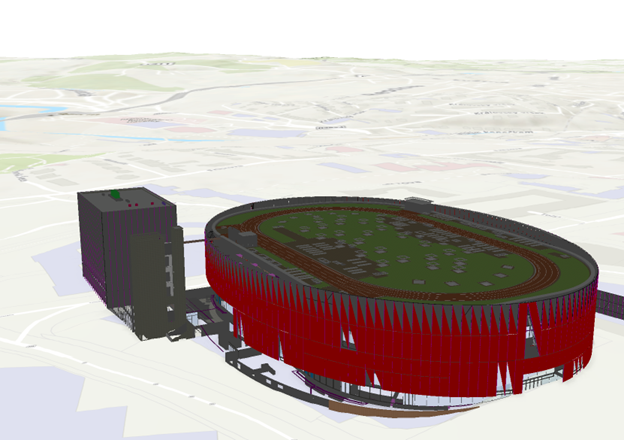


## Use case
City planning departments are increasingly adding digital deliveries to their workflow requirements—especially for 3D digital models (BIM). This sample allows you to improve and update the exterior shell of a building scene layer to better visualize infrastructure. 

## Requirements
- Ensure that all models are already [georeferenced](https://www.esri.com/arcgis-blog/products/arcgis-pro/aec/geolocating-a-digital-model-revit-or-ifc-in-arcgis-pro).
- Create a single dataset with all the relevant models, using the workflow in the [Combine multiple digital models into a single building scene layer](https://www.esri.com/arcgis-blog/products/arcgis-pro/aec/combine-multiple-digital-models-into-a-single-building-scene-layer) blog article.

## How to use the sample
Read this blog for an overview of the script: [Understand and improve the exterior shell of the building layer to support your digital twin](https://www.esri.com/arcgis-blog/products/arcgis-pro/3d-gis/understand-and-improve-the-exterior-shell-of-the-building-layer-to-support-your-digital-twin). Adjust the code in the Jupyter Notebook as needed.


#### Step 1: Set up environment and variables


In [ ]:
import arcpy

# Set the input geodatabase and workspace
input_gdb = r'C:\Projects\Jihlava_MultipurposeAreana_2025.gdb\Multi_Areana'
arcpy.env.workspace = input_gdb

# Define feature class and layer names
exteriorshell_fc = 'ExteriorShell_Multi_Areana'
floors_fc = 'Floors_Multi_Areana'
working_layer = "memory\\ExteriorShell_lyr"
working_floors_layer = "memory\\Floor_lyr"
temp_fc = "ExteriorShell_Temp"

#### Step 2: Create a temporary layer for processing

Make a temporary, in-memory feature layer from the exterior shell feature class.

In [ ]:
# Delete existing temporary layer if it exists
if arcpy.Exists(working_layer):
    arcpy.Delete_management(working_layer)
# Create a feature layer for processing
arcpy.management.MakeFeatureLayer(exteriorshell_fc, working_layer)

#### Step 3: Select elements to exclude from the exterior shell

Filter out features based on the 'DocName' field.

In [ ]:
filter_field = 'DocName'
filter_values = [
    '19_024_JIHL_I_ESI',
    '19_024_JIHL_I_INT',
    '19_024_JIHL_I_PODHLED_AKU',
    '19_024_JIHL_I_TRB',
    '19_024_JIHL_I_VZT',
    '19_024_JIHL_III_ESI',
    '19_024_JIHL_III_INT',
    '19_024_JIHL_III_UTCH',
    '19_024_JIHL_III_VZT'
]
# Build SQL WHERE clause to exclude these DocNames
where_clause = f"{filter_field} NOT IN ({', '.join([repr(name) for name in filter_values])})"
print(where_clause)

In [ ]:
# Select features not in the excluded DocNames
arcpy.management.SelectLayerByAttribute(working_layer, "NEW_SELECTION", where_clause)

#### Step 4: Create a temporary exterior shell feature class

Copy the selected features to a new temporary feature class for further processing.

In [ ]:
# Delete existing temp feature class if it exists
if arcpy.Exists(temp_fc):
    arcpy.Delete_management(temp_fc)

# Copy the selected features to a new feature class
arcpy.management.CopyFeatures(working_layer, temp_fc)

#### Step 5: Add missing floor elements

Select specific floor levels and append them to the temporary exterior shell feature class.

In [ ]:
# Delete existing temporary floor layer if it exists
if arcpy.Exists(working_floors_layer):
    arcpy.Delete_management(working_floors_layer)
# Create a feature layer from the floors feature class
arcpy.management.MakeFeatureLayer(floors_fc, working_floors_layer)

In [ ]:
filter_field = 'BldgLevel'
filter_values = [2, 8, 10]
# Build SQL WHERE clause to select these BldgLevels
floors_where_clause = f"{filter_field} IN ({', '.join([repr(name) for name in filter_values])})"
print(floors_where_clause)

In [ ]:
# Select floor features based on the where clause and append to temp_fc
arcpy.management.SelectLayerByAttribute(working_floors_layer, "NEW_SELECTION", floors_where_clause)
arcpy.management.Append(inputs=working_floors_layer, target=temp_fc, schema_type="NO_TEST")

In [ ]:
# Replace the original exterior shell feature class with the updated one
if arcpy.Exists(exteriorshell_fc):
    arcpy.Delete_management(exteriorshell_fc)
    arcpy.AddMessage('Exterior Shell Layer Deleted')
    arcpy.Rename_management(temp_fc, exteriorshell_fc)
    arcpy.AddMessage('Generalized Layer Renamed to Exterior Shell')
    arcpy.AlterAliasName(exteriorshell_fc, 'ExteriorShell')

#### Step 6: Cleanup (optional)

Optionally, delete temporary layers to keep the workspace clean.

In [ ]:
# Optional cleanup of temporary layers
for lyr in [working_layer, working_floors_layer]:
    if arcpy.Exists(lyr):
        arcpy.Delete_management(lyr)